

##  Time series clusters identified by SOM across all benchmark datasets

This notebook calculates the time seies clustering for the benchmarks of NLP and CVP.

It used the elapsed time from the anchor and the normalized length of the time series across datasets.

The values ploted refers to the percentage of SOTA for a selected metric (Accuracy).

In [ ]:
#Press Control + F9 to run all chunks!

## Install and load required modules. Download datasets to local environment.
(Runtime: 20s)

In [ ]:
#Install modules
!pip install gdown
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install plotly

!pip install minisom
from minisom import MiniSom


#Import modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib
from matplotlib.ticker import ScalarFormatter
import plotly.express as px
import re
import gdown
import plotly.graph_objects as go


%matplotlib inline

#Dowload input files from my Google Drive to local environment.
file_id="1l_HJTdkXNsVfGYRhoq-HgX5Altgrr5c0"
url = 'https://drive.google.com/uc?id=' + file_id
output = 'get_ratio_df_all_per_global_ITO_00101.csv'
gdown.download(url, output, quiet=False)
#
file_id="19uIjeF4ODFAv1RSMbG6uzpZmA6MJEw75"
url = 'https://drive.google.com/uc?id=' + file_id
output = 'get_ratio_df_all_per_global_ITO_00141.csv'
gdown.download(url, output, quiet=False)
#
file_id="1hVB6J4mt-RWsP1AJsqi6R30UyjzNtUuN"
url = 'https://drive.google.com/uc?id=' + file_id
output = 'trajectory_grouping_ITO_00101.csv'
gdown.download(url, output, quiet=False)
#
file_id="1KFd4W69i0ck1mrZCWgvjE5klp-v8M2Vm"
url = 'https://drive.google.com/uc?id=' + file_id
output = 'trajectory_grouping_ITO_00141.csv'
gdown.download(url, output, quiet=False)

#
file_id="1A35O8N-Q1-BqxZhJlccIqa45UHjwGE__"
url = 'https://drive.google.com/uc?id=' + file_id
output = 'df_for_traj_clustering.csv'
gdown.download(url, output, quiet=False)



Downloading...
From: https://drive.google.com/uc?id=1l_HJTdkXNsVfGYRhoq-HgX5Altgrr5c0
To: /content/get_ratio_df_all_per_global_ITO_00101.csv
100%|██████████| 714k/714k [00:00<00:00, 74.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=19uIjeF4ODFAv1RSMbG6uzpZmA6MJEw75
To: /content/get_ratio_df_all_per_global_ITO_00141.csv
100%|██████████| 252k/252k [00:00<00:00, 46.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hVB6J4mt-RWsP1AJsqi6R30UyjzNtUuN
To: /content/trajectory_grouping_ITO_00101.csv
100%|██████████| 22.6k/22.6k [00:00<00:00, 14.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KFd4W69i0ck1mrZCWgvjE5klp-v8M2Vm
To: /content/trajectory_grouping_ITO_00141.csv
100%|██████████| 9.37k/9.37k [00:00<00:00, 9.40MB/s]
Downloading...
From: https://drive.google.com/uc?id=1A35O8N-Q1-BqxZhJlccIqa45UHjwGE__
To: /content/df_for_traj_clustering.csv
100%|██████████| 528k/528k [00:00<00:00, 61.8MB/s]


'df_for_traj_clustering.csv'

## Prepare data for SOM clustering.
(Runtime: 30s)

In [ ]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)

get_ratio_df_all_per_global_CVP = pd.read_csv("get_ratio_df_all_per_global_ITO_00101.csv")
get_ratio_df_all_per_global_CVP["top_class"] = "CVP"

get_ratio_df_all_per_global_NLP = pd.read_csv("get_ratio_df_all_per_global_ITO_00141.csv")
get_ratio_df_all_per_global_NLP["top_class"] = "NLP"

get_ratio_df_all_per_global = get_ratio_df_all_per_global_NLP.append(get_ratio_df_all_per_global_CVP)

get_ratio_df_all_per_global["ds_top_class"] = get_ratio_df_all_per_global["ds"] + " - " + get_ratio_df_all_per_global["top_class"]

#get_ratio_df_all_per_global = get_ratio_df_all_per_global[get_ratio_df_all_per_global["ratio"]!=100]


get_ratio_df_all_per_global = get_ratio_df_all_per_global[get_ratio_df_all_per_global['merge']=="Accuracy"]

get_ratio_df_all_per_global["date"]=pd.to_datetime(get_ratio_df_all_per_global["date"])

#Check this maximum date in order to make sure all the datsets are used, make it a current date
from datetime import date  
from datetime import datetime

todayDate = date.today().strftime('%Y-%m')

headers = pd.date_range('2010-01',todayDate, 
              freq='MS').strftime("%Y-%m").tolist()

#headers = np.arange(0, 100, 0.1)
df = pd.DataFrame(columns=headers, index=get_ratio_df_all_per_global["ds_top_class"].unique())

elsapsed = [*range(0, 240, 1)]

df = pd.DataFrame(columns=elsapsed, index=get_ratio_df_all_per_global["ds_top_class"].unique())
#df = pd.DataFrame(columns=headers, index=get_ratio_df_all_per_global["ds_top_class"].unique())

#get_ratio_df_all_per_global = get_ratio_df_all_per_global[get_ratio_df_all_per_global["ds_top_class"]=="MSVD-QA - Visual Question Answering benchmarking - CVP"]


#1 min to run 
ds_count=0
for ds_top_class in get_ratio_df_all_per_global["ds_top_class"].unique():
  #print("Dataset: " + str(ds_count) + ": "+ds_top_class)
  #get the timeFrame
  timeFrame = max(get_ratio_df_all_per_global[get_ratio_df_all_per_global["ds_top_class"]==ds_top_class]["date"]) - min(get_ratio_df_all_per_global[get_ratio_df_all_per_global["ds_top_class"]==ds_top_class]["date"])
  timeFrame = round(timeFrame/np.timedelta64(1, 'M'),1)
  #print("timeFrame: "+ str(timeFrame))
  if(timeFrame):
    #timeFrame = round(timeFrame/np.timedelta64(1, 'M'),0)

    #count how many values have been collected, only ds with more the 3 values are considered
    count_values=0
    #sets the month anchor
    month_anchor=-1
    #Number here refers to the value used to plot the curve
    number=0
    for date in headers:
      
      #for every date, increase the distance in months rom the anchor
      if(month_anchor!=-1): 
        month_anchor=month_anchor+1
        month_anchor_relative=int(round((month_anchor*100)/timeFrame,0))
      
      #if there is a value to report for a date
      if len(get_ratio_df_all_per_global[(get_ratio_df_all_per_global["ds_top_class"]==ds_top_class) & (get_ratio_df_all_per_global["date"]==date)]["task"]) > 0:
        #sets the month anchor equal to 0 for the first available result
        if(month_anchor==-1): 
          month_anchor=0
          #month_anchor_relative=0
        
        number = get_ratio_df_all_per_global[(get_ratio_df_all_per_global["ds_top_class"]==ds_top_class) & (get_ratio_df_all_per_global["date"]==date)].percent_of_max_sota.iloc[0]
        #save the value for the coordinate ds_top_class,month_anchor
        #print(date + " Found, months from anchor: "+ str(month_anchor) + " (relative: "+ str(month_anchor_relative) + "), Value: "+str(number))
        #df.loc[(ds_top_class,month_anchor)] = number
        df.loc[(ds_top_class,month_anchor_relative)] = number
        #increment the count_values counter
        count_values=count_values+1
      #else: df.loc[(ds_top_class,month_anchor)] = number
      else: 
        month_anchor_relative=0
        #df.loc[(ds_top_class,month_anchor_relative)] = 0
    ds_count=ds_count + 1

  #drop cases where only >2 values have been recorded
  if(count_values <= 2): df.drop([ds_top_class], inplace = True)  

df = df.reindex(sorted(df.columns), axis=1)

#drop dates that do not have values collected for
df.dropna(axis = 1, how = 'all', inplace = True)

#drop datasets that don't have any valid value collected (just in case)
df.dropna(axis = 0, how = 'all', inplace = True)

#how many datasets
#len(df.index.unique())

#Fill with the last result

import math 
last_value = 0

for ds in df.index:
  last_value = 0
  #print(ds)
  for month in df.columns:
    #if the value is a NaN, fill...
    if(math.isnan(df.loc[(ds,month)])): df.loc[(ds,month)] = last_value
    else: last_value = df.loc[(ds,month)]
    #print(str(month) +" | "+str(last_value))
  
print("Run next chunk to get the clusters")

Run next chunk to get the clusters


## Execute Self Organizing Maps clustering
Reference: https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering

(Runtime: 5s)

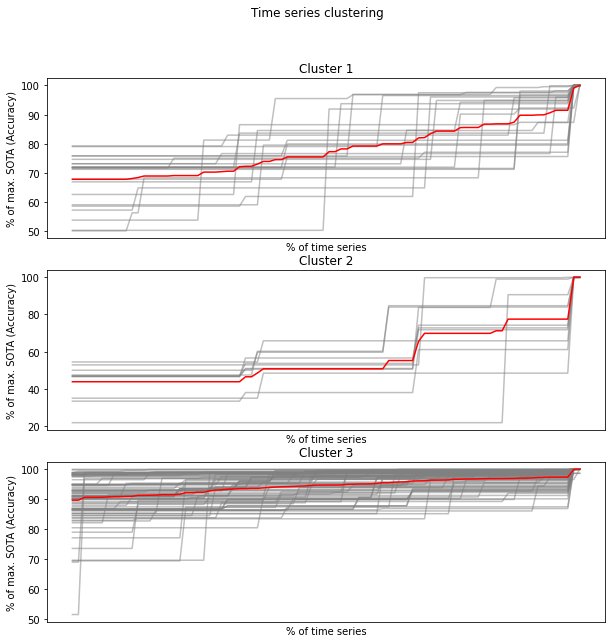

In [ ]:
mySeries = df.values.tolist()

# Little handy function to plot series

def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(10,10))
    fig.suptitle('Time series clustering')      
            
    for x in range(som_x):
      for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[x].plot(series,c="gray",alpha=0.5)
                    axs[x].set_xticks([])
                    axs[x].set_xlabel("% of time series")
                    axs[x].set_ylabel("% of max. SOTA (Accuracy)")
                    #axs[x].set_ylim(0, 100)

                axs[x].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[x].set_title(f"Cluster {cluster_number}")
                
    plt.show()

##

som_x = 3
som_y = 1 # Define here the sub-figures

# Algorithms
som = MiniSom(som_x, som_y,len(mySeries[0]), sigma=0.3, learning_rate = 0.1, random_seed=10)


som.random_weights_init(mySeries)
som.train(mySeries, 50000)


win_map = som.win_map(mySeries)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)


## Cluster distribution
(Runtime: 1s)

In [ ]:
#Plot cluster distribution
cluster_c = []
cluster_n = []

for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

import plotly.express as px

#cluster_c = [round(num,0) for num in cluster_c]

data = {'Cluster':cluster_n,
        'Number of datasets':cluster_c}
  
# Create DataFrame
data = pd.DataFrame(data)


fig = px.bar(data, x='Cluster', y='Number of datasets', text='Number of datasets', height=350, width=1400)
fig.update_traces(texttemplate='%{text}', textposition='outside', marker_color='red')
fig.update_layout(font_size=20, yaxis_range=[0,100])

fig.show()

## Cluster mapping
(Runtime: 1s)

In [ ]:
#Set namesofMySeries
namesofMySeries = df.index

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)

#Perform Cluster Mapping
cluster_map = []
for idx in range(len(df.index)):
    winner_node = som.winner(mySeries[idx])
    cluster_map.append((namesofMySeries[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

df=pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")
df.to_csv("cluster_map.csv",index=True, header=True)
df

,Cluster
Series,
"CIFAR-10, 250 Labels - Semi-Supervised Image Classification benchmarking - CVP",Cluster 1
STL-10 - Image Clustering benchmarking - CVP,Cluster 1
Office-Home - Unsupervised Domain Adaptation benchmarking - CVP,Cluster 1
Extended Yale-B - Image Clustering benchmarking - CVP,Cluster 1
VIVA Hand Gestures Dataset - Hand Gesture Recognition benchmarking - CVP,Cluster 1
CommonsenseQA - Common Sense Reasoning benchmarking - NLP,Cluster 1
VisDA2017 - Domain Adaptation benchmarking - CVP,Cluster 1
USPS - Image Clustering benchmarking - CVP,Cluster 1
MLDoc Zero-Shot English-to-Spanish - Cross-Lingual Document Classification benchmarking - NLP,Cluster 1
